# Character-level Encoder-Decoder Transformer

In this notebook, you will create a machine-translation system that will accept a sentence in a language of your choice and translate it in another language also of your choice.

As architecture, you will use the transformer described in _Attention Is All You Need_ (https://arxiv.org/abs/1706.03762). The complete programming from scratch of such an architecture would take more time than that of a lab. That is why the notebook contains all the code. You will merely run separate modules and assemble them. In the end, this will result in a complete encoder-decoder.

You will train this encoder-decoder for a translation task and you will observe its performance. To make training possible, you will use characters as input and output instead of words or subwords.

The power of the student's computers vary greatly. In consequence, depending on your machine, reduce the size of the dataset and simplify the architecture (use less stacks, less heads) as much as you need to be able to run the program quickly. After the lab, should you wish it, feel free to improve the program and build a more realistic translation system.

Finally, please do not run the cells blindly. The objective of the lab is that you understand the transformer by executing it step-by-step. The instructors will ask you to explain cell.

Acknowledgments: As starting point to write the notebook, we used a tutorial from PyTorch available at: https://pytorch.org/tutorials/beginner/translation_transformer.html?highlight=translation

We modified it to remove the torchtext dependencies and use a character input.

__Pierre Nugues__ and __Marcus Klang__

History:
- V1, Pierre creation from Pytorch tutorial
- V2, Marcus, answering questions and improvements notably dataloader
- V3, Pierre, separate train and val, cleaning


## Introduction
This program shows how to implement a basic character-level translation model with a transformer. You will translate the sentences from English to French or another language character by character. Note that a more elaborate model would use words or subwords.

### Summary of the algorithm
- We start with input sequences from a language (e.g. English sentences)
    and corresponding target sequences from another language
    (e.g. French sentences).
- A transformer encoder encodes the source sentence. The result is called `memory` in the program;
- A transformer decoder uses the encoded source sentence and an auto-regressive process to generate the target sequence.
- The loss is the cross-entropy ebtween the decoded characters and the target ones
- In inference mode, when we decode unknown input sequences using these steps:
    - Encode the input sequence (`memory`)
    - Feed the decoder with the encoded sequence
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Sample the next character using these predictions
        (we simply use argmax, the second output of `torch.max()`).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## Download the data

Have a look at the http://www.manythings.org/anki/ site and select a corpus with at least 10,000 pairs. You should understand the target language well. Ideally, it should be your mother tongue.
Then uncomment and run the lines below.

In [1]:
# !curl -O http://www.manythings.org/anki/swe-eng.zip
# !unzip swe-eng.zip


## Imports

In [2]:
from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence

import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)


## Architecture
We select the computing architecture

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
# elif torch.backends.mps.is_available():
#    device = 'mps'
else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cuda')

## Dataset

### Creating the pairs

In [5]:
data_path = 'swe.txt'


In [6]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")


In [7]:
len(lines)


24610

In [8]:
num_samples = 20000  # Number of samples to train on.


In [9]:
input_texts = []
target_texts = []


In [10]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    input_texts.append(input_text)
    target_texts.append(target_text)


In [11]:
input_texts[500]


'Is Tom mad?'

In [12]:
target_texts[500]


'Är Tom arg?'

### Train/Validation

Percentage train/validation

In [13]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val


16000

We shuffle the lists

In [14]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [15]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]


### Characters

In [16]:
input_characters = set(''.join(train_input_texts))
target_characters = set(''.join(train_target_texts))


### Special symbols

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


In [18]:
special_symbols_dict = dict(
    zip(special_symbols, [UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX]))
special_symbols_dict


{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}

### The input and output symbols
The language pair shares the same vocabulary as in _Attention Is All You Need_

In [19]:
characters = sorted(list(set.union(input_characters, target_characters)))
characters


[' ',
 '!',
 '"',
 '%',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'Ä',
 'Å',
 'Ö',
 'à',
 'ä',
 'å',
 'é',
 'ö',
 '”',
 '€']

### The indices

In [20]:
token2idx = {char: i for i, char in enumerate(characters, start=4)}
token2idx


{' ': 4,
 '!': 5,
 '"': 6,
 '%': 7,
 "'": 8,
 ',': 9,
 '-': 10,
 '.': 11,
 '0': 12,
 '1': 13,
 '2': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '9': 20,
 ':': 21,
 '?': 22,
 'A': 23,
 'B': 24,
 'C': 25,
 'D': 26,
 'E': 27,
 'F': 28,
 'G': 29,
 'H': 30,
 'I': 31,
 'J': 32,
 'K': 33,
 'L': 34,
 'M': 35,
 'N': 36,
 'O': 37,
 'P': 38,
 'Q': 39,
 'R': 40,
 'S': 41,
 'T': 42,
 'U': 43,
 'V': 44,
 'W': 45,
 'Y': 46,
 'a': 47,
 'b': 48,
 'c': 49,
 'd': 50,
 'e': 51,
 'f': 52,
 'g': 53,
 'h': 54,
 'i': 55,
 'j': 56,
 'k': 57,
 'l': 58,
 'm': 59,
 'n': 60,
 'o': 61,
 'p': 62,
 'q': 63,
 'r': 64,
 's': 65,
 't': 66,
 'u': 67,
 'v': 68,
 'w': 69,
 'x': 70,
 'y': 71,
 'z': 72,
 'Ä': 73,
 'Å': 74,
 'Ö': 75,
 'à': 76,
 'ä': 77,
 'å': 78,
 'é': 79,
 'ö': 80,
 '”': 81,
 '€': 82}

In [21]:
token2idx.update(special_symbols_dict)
token2idx


{' ': 4,
 '!': 5,
 '"': 6,
 '%': 7,
 "'": 8,
 ',': 9,
 '-': 10,
 '.': 11,
 '0': 12,
 '1': 13,
 '2': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '9': 20,
 ':': 21,
 '?': 22,
 'A': 23,
 'B': 24,
 'C': 25,
 'D': 26,
 'E': 27,
 'F': 28,
 'G': 29,
 'H': 30,
 'I': 31,
 'J': 32,
 'K': 33,
 'L': 34,
 'M': 35,
 'N': 36,
 'O': 37,
 'P': 38,
 'Q': 39,
 'R': 40,
 'S': 41,
 'T': 42,
 'U': 43,
 'V': 44,
 'W': 45,
 'Y': 46,
 'a': 47,
 'b': 48,
 'c': 49,
 'd': 50,
 'e': 51,
 'f': 52,
 'g': 53,
 'h': 54,
 'i': 55,
 'j': 56,
 'k': 57,
 'l': 58,
 'm': 59,
 'n': 60,
 'o': 61,
 'p': 62,
 'q': 63,
 'r': 64,
 's': 65,
 't': 66,
 'u': 67,
 'v': 68,
 'w': 69,
 'x': 70,
 'y': 71,
 'z': 72,
 'Ä': 73,
 'Å': 74,
 'Ö': 75,
 'à': 76,
 'ä': 77,
 'å': 78,
 'é': 79,
 'ö': 80,
 '”': 81,
 '€': 82,
 '<unk>': 0,
 '<pad>': 1,
 '<bos>': 2,
 '<eos>': 3}

In [22]:
len(token2idx)


83

In [23]:
idx2token = {v: k for k, v in token2idx.items()}


### Text Encoding

In [24]:
def text2codes(texts, token2idx):
    codes = []
    for text in texts:
        text_l = ['<bos>'] + list(text) + ['<eos>']
        codes += torch.tensor([list(map(lambda x: token2idx.get(x, 0), text_l))]) # <unk> -> 0
    return codes


In [25]:
train_input_texts[:3], train_target_texts[:3]


(['Check that.', "That's absolutely correct.", 'Tom nodded.'],
 ['Kolla det där.', 'Det är alldeles korrekt.', 'Tom nickade.'])

In [26]:
text2codes(train_input_texts, token2idx)[:3]


[tensor([ 2, 25, 54, 51, 49, 57,  4, 66, 54, 47, 66, 11,  3]),
 tensor([ 2, 42, 54, 47, 66,  8, 65,  4, 47, 48, 65, 61, 58, 67, 66, 51, 58, 71,
          4, 49, 61, 64, 64, 51, 49, 66, 11,  3]),
 tensor([ 2, 42, 61, 59,  4, 60, 61, 50, 50, 51, 50, 11,  3])]

In [27]:
text2codes(train_target_texts, token2idx)[:3]


[tensor([ 2, 33, 61, 58, 58, 47,  4, 50, 51, 66,  4, 50, 77, 64, 11,  3]),
 tensor([ 2, 26, 51, 66,  4, 77, 64,  4, 47, 58, 58, 50, 51, 58, 51, 65,  4, 57,
         61, 64, 64, 51, 57, 66, 11,  3]),
 tensor([ 2, 42, 61, 59,  4, 60, 55, 49, 57, 47, 50, 51, 11,  3])]

In [28]:
def codes2text(codes, idx2token):
    texts = []
    for code in codes:
        code_l = list(code)
        texts += [list(map(lambda x: idx2token.get(x.item(), 0), code_l))]
    return texts


In [29]:
codes2text(text2codes(train_input_texts, token2idx)[:3], idx2token)


[['<bos>', 'C', 'h', 'e', 'c', 'k', ' ', 't', 'h', 'a', 't', '.', '<eos>'],
 ['<bos>',
  'T',
  'h',
  'a',
  't',
  "'",
  's',
  ' ',
  'a',
  'b',
  's',
  'o',
  'l',
  'u',
  't',
  'e',
  'l',
  'y',
  ' ',
  'c',
  'o',
  'r',
  'r',
  'e',
  'c',
  't',
  '.',
  '<eos>'],
 ['<bos>', 'T', 'o', 'm', ' ', 'n', 'o', 'd', 'd', 'e', 'd', '.', '<eos>']]

## Model

### Positional Embeddings

Same as https://pytorch.org/tutorials/beginner/translation_transformer.html?highlight=translation

Note that `register_buffer` is a way to exclude `pos_embeddings` from being a parameter and stored as state, essentially a way to register a computed constant. It will not be modified by the training procedure.

In [30]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


In [31]:
pe = PositionalEncoding(10, 0.1)


In [32]:
torch.zeros(1, 5, 10)


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [33]:
pe(torch.zeros(1, 5, 10))


tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 0.0000, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

### Token Embeddings

In [34]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


### Transformer

Same as https://pytorch.org/tutorials/beginner/translation_transformer.html?highlight=translation

Note that:   
- `transformer.encoder(...)` is equivalent to a call of TransformerEncoder(...), i.e https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html    
- `transformer.decoder(...)` is equivalent to a call of TransformerDecoder(...), i.e https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html   
- These are created internally by the transformer layer:
https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer  

In [35]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.tgt_tok_emb(tgt)), memory,
            tgt_mask)


In [36]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask


In [37]:
generate_square_subsequent_mask(10)


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [38]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [39]:
src = pad_sequence(text2codes(
    train_input_texts[:3], token2idx), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], token2idx), padding_value=PAD_IDX)


In [40]:
train_input_texts[:3], train_target_texts[:3]


(['Check that.', "That's absolutely correct.", 'Tom nodded.'],
 ['Kolla det där.', 'Det är alldeles korrekt.', 'Tom nickade.'])

The tensors. Note the batch dimension is the second one.

In [ ]:
src


tensor([[ 2,  2,  2],
        [25, 42, 42],
        [54, 54, 61],
        [51, 47, 59],
        [49, 66,  4],
        [57,  8, 60],
        [ 4, 65, 61],
        [66,  4, 50],
        [54, 47, 50],
        [47, 48, 51],
        [66, 65, 50],
        [11, 61, 11],
        [ 3, 58,  3],
        [ 1, 67,  1],
        [ 1, 66,  1],
        [ 1, 51,  1],
        [ 1, 58,  1],
        [ 1, 71,  1],
        [ 1,  4,  1],
        [ 1, 49,  1],
        [ 1, 61,  1],
        [ 1, 64,  1],
        [ 1, 64,  1],
        [ 1, 51,  1],
        [ 1, 49,  1],
        [ 1, 66,  1],
        [ 1, 11,  1],
        [ 1,  3,  1]])

In [42]:
tgt


tensor([[ 2,  2,  2],
        [33, 26, 42],
        [61, 51, 61],
        [58, 66, 59],
        [58,  4,  4],
        [47, 77, 60],
        [ 4, 64, 55],
        [50,  4, 49],
        [51, 47, 57],
        [66, 58, 47],
        [ 4, 58, 50],
        [50, 50, 51],
        [77, 51, 11],
        [64, 58,  3],
        [11, 51,  1],
        [ 3, 65,  1],
        [ 1,  4,  1],
        [ 1, 57,  1],
        [ 1, 61,  1],
        [ 1, 64,  1],
        [ 1, 64,  1],
        [ 1, 51,  1],
        [ 1, 57,  1],
        [ 1, 66,  1],
        [ 1, 11,  1],
        [ 1,  3,  1]])

The next function returns `src_mask`, `tgt_mask`, `src_padding_mask`, `tgt_padding_mask`.

In [43]:
create_mask(src, tgt)


(tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          Fa

## Model Creation

In [44]:
len(characters)


79

In [45]:
len(token2idx)


83

In [46]:
SRC_VOCAB_SIZE = max(token2idx.values()) + 1  # or len(token2idx)
TGT_VOCAB_SIZE = max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


In [47]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


## Formatting the Data
We use `Dataset` and `DataLoader`. `Dataset` implements two methods: `__init__`, `__len__` and `__getitem__`. The last method returns an item of the dataset given an index. Using `collate_fn`, `DataLoader` returns a batch of `batch_size` samples.

In [48]:
from torch.utils.data import Dataset, DataLoader


In [49]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch


In [50]:
train_dataset = PairDataset(train_input_texts, train_target_texts, token2idx)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)


In [51]:
val_dataset = PairDataset(val_input_texts, val_target_texts, token2idx)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)


## Training Loop

In [52]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


About the loss. Overall, it should computed by individual prediction and divided by the number of chars. By default the crossentropy loss uses the mean. Then we use the mean of the mean. The trend is correct, but the values are not exact. A possible improvement would be to sum and pass through the mask.

In [53]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [54]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


Epoch: 1, Train loss: 0.062, Val loss: 0.048, Train acc.: 0.256, Val acc.: 0.325, Epoch time = 21.219s


100%|██████████| 500/500 [00:21<00:00, 22.80it/s]


Epoch: 2, Train loss: 0.048, Val loss: 0.040, Train acc.: 0.326, Val acc.: 0.366, Epoch time = 21.935s


100%|██████████| 500/500 [00:20<00:00, 24.26it/s]


Epoch: 3, Train loss: 0.043, Val loss: 0.036, Train acc.: 0.355, Val acc.: 0.392, Epoch time = 20.614s


100%|██████████| 500/500 [00:20<00:00, 24.03it/s]


Epoch: 4, Train loss: 0.039, Val loss: 0.032, Train acc.: 0.376, Val acc.: 0.411, Epoch time = 20.816s


100%|██████████| 500/500 [00:21<00:00, 23.67it/s]


Epoch: 5, Train loss: 0.037, Val loss: 0.030, Train acc.: 0.390, Val acc.: 0.425, Epoch time = 21.133s


100%|██████████| 500/500 [00:21<00:00, 23.63it/s]


Epoch: 6, Train loss: 0.034, Val loss: 0.027, Train acc.: 0.405, Val acc.: 0.440, Epoch time = 21.167s


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


Epoch: 7, Train loss: 0.032, Val loss: 0.026, Train acc.: 0.413, Val acc.: 0.451, Epoch time = 21.275s


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


Epoch: 8, Train loss: 0.031, Val loss: 0.024, Train acc.: 0.423, Val acc.: 0.459, Epoch time = 21.431s


100%|██████████| 500/500 [00:21<00:00, 22.92it/s]


Epoch: 9, Train loss: 0.029, Val loss: 0.022, Train acc.: 0.431, Val acc.: 0.468, Epoch time = 21.824s


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


Epoch: 10, Train loss: 0.028, Val loss: 0.021, Train acc.: 0.441, Val acc.: 0.478, Epoch time = 21.458s


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


Epoch: 11, Train loss: 0.027, Val loss: 0.019, Train acc.: 0.447, Val acc.: 0.487, Epoch time = 21.415s


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


Epoch: 12, Train loss: 0.025, Val loss: 0.018, Train acc.: 0.454, Val acc.: 0.494, Epoch time = 21.441s


100%|██████████| 500/500 [00:21<00:00, 23.10it/s]


Epoch: 13, Train loss: 0.024, Val loss: 0.017, Train acc.: 0.459, Val acc.: 0.500, Epoch time = 21.651s


100%|██████████| 500/500 [00:21<00:00, 23.09it/s]


Epoch: 14, Train loss: 0.023, Val loss: 0.016, Train acc.: 0.465, Val acc.: 0.506, Epoch time = 21.661s


100%|██████████| 500/500 [00:21<00:00, 23.01it/s]


Epoch: 15, Train loss: 0.022, Val loss: 0.015, Train acc.: 0.471, Val acc.: 0.513, Epoch time = 21.738s


## Plotting the Loss

In [55]:
epochs = range(NUM_EPOCHS)


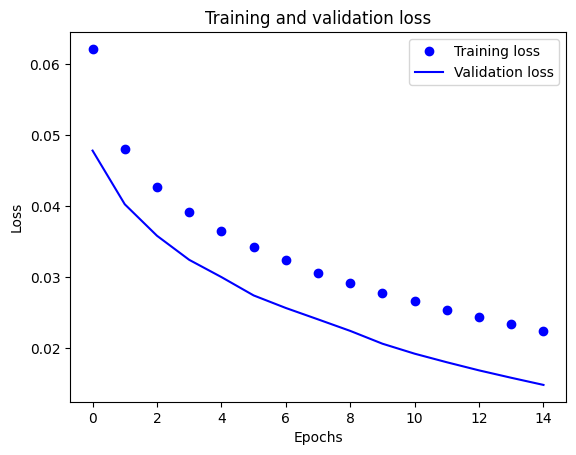

In [56]:
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


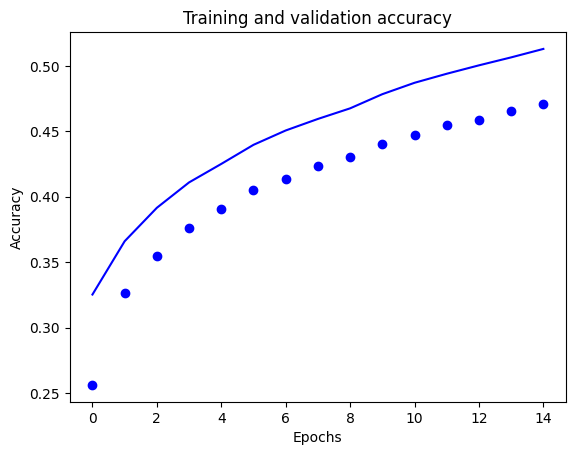

In [57]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


## Application

In [58]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == EOS_IDX:
            break
    return ys


In [59]:
text2codes(['Go!'], token2idx)[0].view(-1, 1)


tensor([[ 2],
        [29],
        [61],
        [ 5],
        [ 3]])

In [60]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], token2idx)[0].view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    tgt_chars_specials = codes2text([tgt_tokens], idx2token)[0]
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<bos>' and char != '<eos>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [61]:
tgt_sent = translate(transformer, 'Will you come home?')
tgt_sent


'Kommer du hem?'

In [62]:
tgt_sent = translate(
    transformer, "Eine Gruppe von Menschen steht vor einem Iglu .")
tgt_sent


'En uppratar människor jag med det här.'

## Save model

In [63]:

torch.save(transformer, 'simple_params_v3.pth')


## Report
In your report, you will first summarize the paper _Attention Is All You Need_ (https://arxiv.org/abs/1706.03762) in about half a page. You will then describe the encoder-decoder architecture in the notebook.

Please follow the outline below and use the same section names as those in bold:
- __Dataset__: Describe your dataset;
- __Encoder-Decoder__: Describe the overall architecture;
- __Embeddings__: Explain the embeddings, positional encodings and character embeddings
- __Self-Attention__: Explain self-attention
- __Decoder__: Describe the decoder
- __Inference__: Describe the inference
- __Experiments and Results__: Describe and comment your experiments and results. You should try at least two sets of parameters (e.g. number of heads, number of layers, number of epochs, etc.)